# Dev notebook for updates

`No development at the moment`

In [ ]:
import numpy as np
from dmrg_src.MPS import MPS 
from dmrg_src.MPO import MPO_TFI
from dmrg_src.cont import CONT
# from dmrg_src.dmrg import dmrg
from dmrg.obs import observables

import matplotlib.pyplot as plt
import os
import shutil

### Class 

In [ ]:
# import numpy as np

# from .MPS import MPS
# from .cont import CONT
from dmrg_src.lanczos import EffH

class dmrg():
    """
        Class that runs the DMRG algorithm on a 1 dimensional system

            Attributes:
                - cont: Class DMRG.contractions
    """

    def __init__(self,cont,chi=100,cut=1e-12):
        self.cont = cont
        self.mps = cont.mps
        self.chi = chi
        self.h = cont.h
        self.L = cont.L
        self.count = cont.count
        self.cut = cut
        self.d = self.mps.d

    
    def infinite(self):

        En = np.zeros(self.L//2-1)
        
        env_left = self.cont.left(self.L%2)
        env_right = self.cont.right(self.L-1)

        for i in range(1,self.mps.L//2):

            H = EffH(env_left,env_right,self.h,site=i)
            En[i-1],grd = H.lanczos_grd()

            mat = np.reshape(grd,(H.c1*H.d,H.d*H.c2))
            l,c,r = np.linalg.svd(mat)

            bound = min(len(c[c>self.cut]),self.chi)
           
            l = l[:,:bound]
            c = c[:bound]
            r = r[:bound,:]

            self.mps.write_left(i+self.L%2,l)
            self.mps.write_right(self.mps.L-i-1,r)
            
            env_left = self.cont.add(i+self.L%2,'l')
            env_right = self.cont.add(self.mps.L-i-1,'r')
            
        self.mps.writeS(i+self.L%2,np.diag(c))

        return En

    def step2sites(self,site,dir,exc='off',stage=None):

        env_left,env_right = self.cont.env_prep(site)
    
        H = EffH(env_left,env_right,self.h,site=site)

        if dir == 'l' or dir == 'bl':
            init_vec = np.tensordot(self.mps.read(site),np.tensordot(self.mps.read(site+1),self.mps.readS(site+1),(2,0)),(2,1))
            init_vec = dmrg.remish(init_vec)
        if dir == 'r' or dir == 'br':
            init_vec = np.tensordot(np.tensordot(self.mps.readS(site-1),self.mps.read(site),(0,1)),self.mps.read(site+1),(2,1))

        init_vec = np.reshape(init_vec,np.prod(init_vec.shape))
        
        if stage == None:
            print('Before ',np.conj(init_vec)@H.matvec(init_vec))
            En,grd = H.lanczos_grd(psi0=None,exc=exc)
            grd_state = 1/np.sqrt(np.conj(grd)@grd)*grd
            print('After ', En.real,' Diff ',En - np.conj(grd_state)@H.matvec(grd_state))
        if stage == 'Final':
            grd_state = 1/np.sqrt(init_vec@np.conj(init_vec))*init_vec
            En = np.conj(grd_state)@H.matvec(grd_state)
        
        grd_state = np.reshape(grd_state,(H.c1*H.d,H.d*H.c2))

        l,c,r = np.linalg.svd(grd_state,full_matrices=False)
        
        bound = min(len(c[c**2>self.cut]),self.chi)
        l = l[:,:bound]
        c = c[:bound]
        r = r[:bound,:]
        
        self.mps.write_left(site,l)
        self.mps.write_right(site+1,r)
        self.mps.writeS(site,np.diag(c))

        if dir == 'r':
            self.cont.add(site,'l')
            if site == self.L -3:
                self.cont.add(site+1,'r')
        
        if dir == 'l':
            self.cont.add(site+1,'r')
            if site == 1:
                self.cont.add(site,'l')
        
        return En, -c**2@np.log(c**2)


    def remish(ten):
        d0,d1,d2,d3 = ten.shape
        res = np.zeros((d1,d0,d2,d3),dtype='complex')
        for i0 in range(d0):
            for i1 in range(d1):
                res[i1,i0,:,:] = ten[i0,i1,:,:]

        return res
    

In [ ]:
class MPO_AL():

    Id2 = np.identity(2)
    Id4 = np.identity(4)
    Sp = np.array([[0,1],[0,0]])
    Sm = np.array([[0,0],[1,0]])
    Z = np.array([[1,0],[0,-1]])
    d = 4

    sub_BC = [0,2,3]
    sub_A = [1,4]

    def __init__(self,t_1,t_2,U,e_A,mu):
        self.t_1 = t_1
        self.t_2 = t_2
        self.U = U
        self.e_A = e_A
        self.mu = mu
        self.OP = [np.kron(MPO_AL.Sm,MPO_AL.Id2),np.kron(MPO_AL.Sp,MPO_AL.Id2),np.kron(MPO_AL.Z,MPO_AL.Sm),np.kron(MPO_AL.Z,MPO_AL.Sp)]
        self.coeff = [[self.t_1,self.t_2,self.t_2,0,0],
                    [self.t_1,self.t_2,self.t_1,0,self.t_2],
                    [0,self.t_2,self.t_1,0,self.t_2],
                    [0,self.t_1,self.t_2,0,self.t_2],
                    [0,self.t_1,0,0,self.t_2]]

    
    def mpo(self,p):

        MPO = np.zeros((4,4,22,22))

        MPO[:,:,0,0] = MPO_AL.Id4
        MPO[:,:,0,1] = np.kron(MPO_AL.Sp,MPO_AL.Z)
        MPO[:,:,0,6] = np.kron(MPO_AL.Sm,MPO_AL.Z)
        MPO[:,:,0,11] = np.kron(MPO_AL.Id2,MPO_AL.Sp)
        MPO[:,:,0,16] = np.kron(MPO_AL.Id2,MPO_AL.Sm)
        MPO[:,:,0,21] = -self.mu*(np.kron(MPO_AL.Z,MPO_AL.Id2) + np.kron(MPO_AL.Id2,MPO_AL.Z))

        # sublattice conditions
        if (p-1)%5 in MPO_AL.sub_BC:
            MPO[:,:,0,21] += self.U*np.kron(MPO_AL.Z,MPO_AL.Z)
        
        if (p-1)%5 in MPO_AL.sub_A:
            MPO[:,:,0,21] += self.e_A*(np.kron(MPO_AL.Z,MPO_AL.Id2) + np.kron(MPO_AL.Id2,MPO_AL.Z))

        for j in range(4):
            for i in range(4):
                MPO[:,:,1 +j*5 +i,2+j*5+i] = np.kron(MPO_AL.Z,MPO_AL.Z)

        
        for j in range(1,6):
            for i in range(4):
                MPO[:,:,j+5*i,21] = self.coeff[(p-1)%5][j-1]*self.OP[i]

        MPO[:,:,21,21] = MPO_AL.Id4

        return MPO

    def Wl(self):

        Wleft = np.zeros((4,4,22))

        Wleft[:,:,0] = MPO_AL.Id4
        Wleft[:,:,1] = np.kron(MPO_AL.Sp,MPO_AL.Z)
        Wleft[:,:,6] = np.kron(MPO_AL.Sm,MPO_AL.Z)
        Wleft[:,:,11] = np.kron(MPO_AL.Id2,MPO_AL.Sp)
        Wleft[:,:,16] = np.kron(MPO_AL.Id2,MPO_AL.Sm)
        Wleft[:,:,21] = (-self.mu + self.e_A )*(np.kron(MPO_AL.Z,MPO_AL.Id2) + np.kron(MPO_AL.Id2,MPO_AL.Z)) 

        return Wleft

    def Wr(self):

        Wright = np.zeros((4,4,22))

        for j in range(1,6):
            for i in range(4):
                Wright[:,:,j+5*i] = self.coeff[1][j-1]*self.OP[i]

        Wright[:,:,21] = MPO_AL.Id4

        return Wright

### Test

In [ ]:
L = 18
mps = MPS(L,d=4)
h = MPO_AL(t_1=-1,t_2=-1,U=20,e_A=10,mu=5)
cont = CONT(mps,h) 
sys = dmrg(cont,chi=2)
obs = observables(mps)
mps.random()
cont.random()

# create folder out if not present
path_out = 'OUT/'
if os.path.isdir(path_out):
    shutil.rmtree(path_out)
os.mkdir(path_out)


sys.chi = 100
EE = []
EE_pre = []
k = 0 


for site,dir in mps.first_sweep():
    # print(site)
    En,_ = sys.step2sites(site,dir=dir,stage='Final')
    # EE.append(En)

for site,dir in mps.sweep():
    En,_ = sys.step2sites(site,dir=dir)
    EE.append(En)

for site,dir in mps.sweep():
    En,_ = sys.step2sites(site,dir=dir)
    EE.append(En)

# Final sweep to store observables
for site,dir in mps.right_sweep():
    _,S = sys.step2sites(site,dir=dir,stage='Final')

    # Store local magnetization
    if site == 2:
        o1,o2 = obs.bound_left(site-1,h.Z)
        with open(path_out + 'ZZ.txt','a') as fz:
            fz.write(f'{site} {o1.real} \n')
            fz.write(f'{site} {o2.real} \n')

    with open(path_out + 'ZZ.txt','a') as fz:
            fz.write(f'{site} {obs.single_site(site,h.Z).real} \n')

    if site == L-3:
        o1,o2 = obs.bound_right(site+1,h.Z)
        with open(path_out + 'ZZ.txt','a') as fz:
            fz.write(f'{site} {o1.real} \n')
            fz.write(f'{site} {o2.real} \n')

    # Store entanglement entropy
    with open(path_out + 'S.txt','a') as fz:
            fz.write(f'{site} {site+1} {S} \n')

    # Store all two point correlations from site

    obs.all_corr(path_out + 'ZZstring.txt',site,string=h.Z,obs1=h.Z)
    obs.all_corr(path_out + 'ZZcorr.txt',site,string=h.Id,obs1=h.Z)

    if site == 10:
        ZZ_10_13 = obs.two_sites(site,site+3,string=h.Id,obs1=h.Id)

plt.plot(EE[1:])

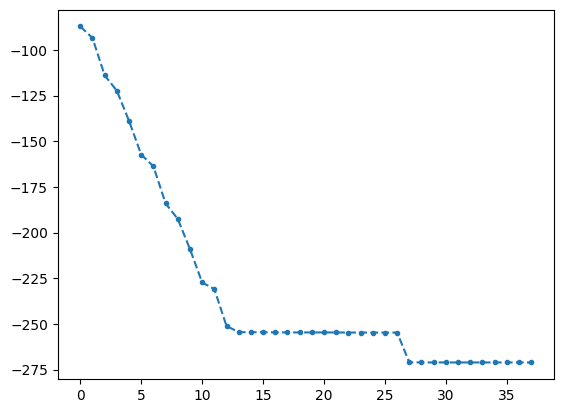

In [17]:
plt.plot(EE,'.--')

In [ ]:
from itertools import product
dim = [4,2,2]
Id4 = np.identity(4)
res = np.zeros((2,2,4))
ranges = [range(d) for d in dim]
for i in product(*ranges):
    res[i[0],i[1],i[2]] =Id4[i[0]i[1]i[2]]

In [ ]:
d=4
a = np.reshape(np.identity(d**2)[:,:d],(d,d,d))
np.tensordot(a,a,((0,1),(0,1)))